# Zohran Mamdani NYC policy costs calculator

In [46]:


## Data source 1 : https://comptroller.nyc.gov/reports/annual-comprehensive-financial-reports/

### Data obtained from: page 42 of pdf file "NYC_ACFR_2025.pdf"

### 1. Imports

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [48]:
rng = np.random.default_rng(42)

### 2. FY 2025 Baseline Data (from ACFR Statement of Activities)

All values below are copied directly from the FY 2025 ACFR, Statement of Activities, Governmental Activities section.
They are reported in thousands of dollars in the ACFR, and we convert to dollars in the code.

In [49]:
## These valyes are in thousands of dollars and are from NYC's 2025 adopted budget from the link above
expense_k = {
    "general_gov":      9186394,     # General government
    "public_safety":    22582353,    # Public safety
    "education":        37499336,    # Education
    "city_university":  1284327,     # City University
    "social_services":  21381772,    # Social services
    "environment":      5008453,     # Environment
    "transport":        4801397,     # Transportation
    "parks_culture":    1342602,     # Parks and culture
    "housing":          5303329,     # Housing
    "health":           6640344,     # Health
    "libraries":        392600,      # Libraries
    "debt_service":     3852280      # Debt service
}

In [50]:
# Total program revenue (governmental activities, IN THOUSANDS)
# Total governmental activities:
#     Charges for Services:        6,342,716
#     Operating Grants:           29,894,787
#     Capital Grants:                798,646
# TOTAL_PROGREV_2025_K = 6,342,716 + 29,894,787 + 798,646
TOTAL_PROGREV_2025_K = 55471756  

# Total general revenue (IN THOUSANDS)
TOTAL_GENREV_2025_K  = 82618047  

In [51]:
# Convert to dollars
expense = {k: v * 1000 for k, v in expense_k.items()}
TOTAL_PROGREV_2025 = TOTAL_PROGREV_2025_K * 1000
TOTAL_GENREV_2025  = TOTAL_GENREV_2025_K * 1000

TOTAL_EXPENSE_2025 = sum(expense.values())
TOTAL_REVENUE_2025 = TOTAL_PROGREV_2025 + TOTAL_GENREV_2025

print("Baseline FY 2025:")
print("Total expenses:", f"${TOTAL_EXPENSE_2025:,.0f}")
print("Total revenue:",  f"${TOTAL_REVENUE_2025:,.0f}")
print("Surplus/deficit:", f"${TOTAL_REVENUE_2025 - TOTAL_EXPENSE_2025:,.0f}")


Baseline FY 2025:
Total expenses: $119,275,187,000
Total revenue: $138,089,803,000
Surplus/deficit: $18,814,616,000


In [52]:
baseline_summary = pd.DataFrame(
    {
        "Amount ($)": [
            TOTAL_EXPENSE_2025,
            TOTAL_REVENUE_2025,
            TOTAL_REVENUE_2025 - TOTAL_EXPENSE_2025,
        ]
    },
    index=["Total expenses", "Total revenues", "Surplus / (deficit)"],
)

### 3. Monte Carlo Settings

We’ll allow 10% noise around each baseline expense and revenue to represent forecast uncertainty.

In [53]:
# Number of Monte Carlo runs
N = 100000

In [54]:
# Baseline volatility assumptions (10% noise)
baseline_expense_noise = 0.10
baseline_revenue_noise = 0.10

In [55]:
functions = list(expense.keys())

In [56]:
# Draw baseline expense paths by function
baseline_expense_draws = {}

In [57]:
for f in functions:
    mean_val = expense[f]
    std_val = baseline_expense_noise * mean_val
    draws = np.random.normal(mean_val, std_val, N)
    draws = np.maximum(draws, 0)  # no negative expenses
    baseline_expense_draws[f] = draws

In [58]:
# Baseline revenue draws
baseline_revenue_draws = np.random.normal(
    TOTAL_REVENUE_2025,
    TOTAL_REVENUE_2025 * baseline_revenue_noise,
    N,
)
baseline_revenue_draws = np.maximum(baseline_revenue_draws, 0)

In [59]:
# Aggregate baseline total expenses and surplus
baseline_total_expense = np.zeros(N)
for f in functions:
    baseline_total_expense += baseline_expense_draws[f]

baseline_surplus = baseline_revenue_draws - baseline_total_expense

### 4. Zohran Mamdani Policy Package – Cost Assumptions

These are stylized annual cost assumptions.

In [60]:
# Grocery stipend / relief
grocery_mean = 60000000
grocery_std  = 12000000   # 20% noise

In [61]:
# Free buses (citywide bus fares)
free_bus_mean = 711507000
free_bus_std  = 150000000

In [62]:
# Rent freeze support / aid / tax expenditure (spread over 4 years)
rent_freeze_mean = 6840000000 / 4
rent_freeze_std  = 400000000

In [63]:
# Admin overhead to manage new programs
admin_mean = 50000000
admin_std  = 20000000

In [64]:
# Landlord compensation / legal settlements (rare)
landlord_prob = 0.05
landlord_mean = 1500000000
landlord_std  = 500000000

In [65]:
# New progressive tax package to fund policies
new_tax_mean = 10000000000
new_tax_std  = 2000000000

#### Map each policy to the budget function it primarily affects:

In [66]:
policy_to_function = {
    "grocery":        "social_services",
    "free_bus":       "transport",
    "rent_freeze":    "housing",
    "admin":          "general_gov",
    "landlord_comp":  "housing",
}

In [67]:
### 5. Policy Cost Draws & New Tax Revenue Draws

In [68]:
# Empty containers for additional policy costs by function
policy_cost_by_func = {f: np.zeros(N) for f in functions}

In [69]:
# Grocery
grocery = np.random.normal(grocery_mean, grocery_std, N)
grocery = np.maximum(grocery, 0)
policy_cost_by_func[policy_to_function["grocery"]] += grocery

In [70]:
# Free buses
free_bus = np.random.normal(free_bus_mean, free_bus_std, N)
free_bus = np.maximum(free_bus, 0)
policy_cost_by_func[policy_to_function["free_bus"]] += free_bus


In [71]:
# Rent freeze support
rent_freeze = np.random.normal(rent_freeze_mean, rent_freeze_std, N)
rent_freeze = np.maximum(rent_freeze, 0)
policy_cost_by_func[policy_to_function["rent_freeze"]] += rent_freeze

In [72]:
# Admin overhead
admin_cost = np.random.normal(admin_mean, admin_std, N)
admin_cost = np.maximum(admin_cost, 0)
policy_cost_by_func[policy_to_function["admin"]] += admin_cost

In [73]:
# Landlord compensation (rare event)
landlord_event = np.random.rand(N) < landlord_prob
landlord_cost = np.random.normal(landlord_mean, landlord_std, N)
landlord_cost = np.maximum(landlord_cost, 0) * landlord_event
policy_cost_by_func[policy_to_function["landlord_comp"]] += landlord_cost

In [74]:
# New tax revenue
new_tax = np.random.normal(new_tax_mean, new_tax_std, N)
new_tax = np.maximum(new_tax, 0)

### 6. Surplus / Deficit With Policy Package

In [75]:
# Total policy expense per simulation
total_policy_expense = np.zeros(N)
for f in functions:
    total_policy_expense += policy_cost_by_func[f]

# Expenses and revenues with policies
expense_with_policy = baseline_total_expense + total_policy_expense
revenue_with_policy = baseline_revenue_draws + new_tax

surplus_with_policy = revenue_with_policy - expense_with_policy

### 7. Baseline vs With Policies

In [76]:
# Compute summary metrics
def summarize_array(arr):
    mean_val = np.mean(arr)
    median_val = np.median(arr)
    p5 = np.percentile(arr, 5)
    p95 = np.percentile(arr, 95)
    prob_surplus = np.mean(arr >= 0)
    return mean_val, median_val, p5, p95, prob_surplus

In [77]:
base_mean, base_med, base_p5, base_p95, base_prob = summarize_array(baseline_surplus)
pol_mean, pol_med, pol_p5, pol_p95, pol_prob = summarize_array(surplus_with_policy)

In [78]:
summary_df = pd.DataFrame(
    {
        "Scenario": ["Baseline 2025", "With Mamdani policies"],
        "Mean surplus ($)": [base_mean, pol_mean],
        "Median surplus ($)": [base_med, pol_med],
        "5th percentile ($)": [base_p5, pol_p5],
        "95th percentile ($)": [base_p95, pol_p95],
        "Prob(surplus ≥ 0)": [base_prob, pol_prob],
    }
)

In [79]:
summary_df.style.format(
    {
        "Mean surplus ($)": "{:,.0f}",
        "Median surplus ($)": "{:,.0f}",
        "5th percentile ($)": "{:,.0f}",
        "95th percentile ($)": "{:,.0f}",
        "Prob(surplus ≥ 0)": "{:.2%}",
    }
)

,Scenario,Mean surplus ($),Median surplus ($),5th percentile ($),95th percentile ($),Prob(surplus ≥ 0)
0,Baseline 2025,"18,770,695,054","18,690,641,408","-5,525,199,159","43,057,598,160",89.96%
1,With Mamdani policies,"26,167,238,493","26,084,438,915","1,593,523,421","50,644,396,001",96.08%


#### 8. Visualize the Surplus Distributions

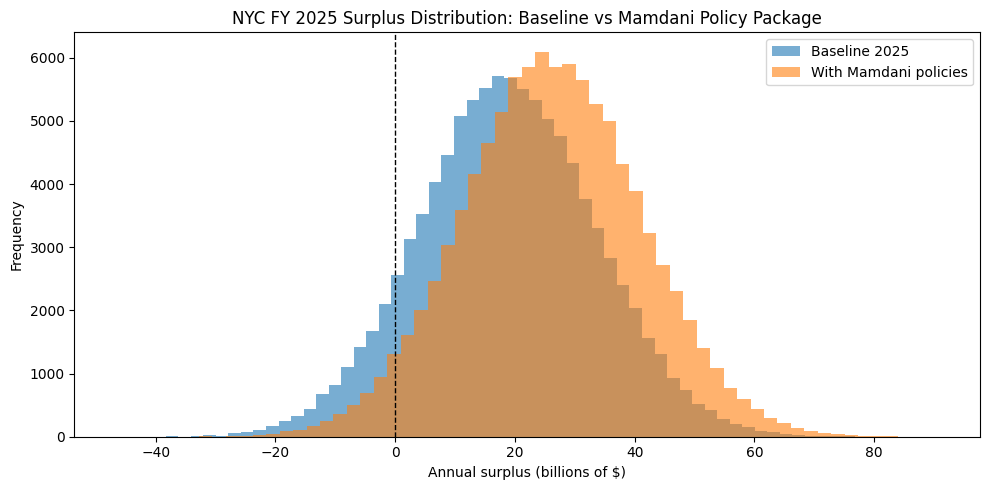

In [80]:
plt.figure(figsize=(10, 5))
plt.hist(baseline_surplus / 1e9, bins=60, alpha=0.6, label="Baseline 2025")
plt.hist(surplus_with_policy / 1e9, bins=60, alpha=0.6, label="With Mamdani policies")
plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.xlabel("Annual surplus (billions of $)")
plt.ylabel("Frequency")
plt.title("NYC FY 2025 Surplus Distribution: Baseline vs Mamdani Policy Package")
plt.legend()
plt.tight_layout()
plt.show()

#### Q. Which Functions Are Most Stressed by the Policy Package?

In [81]:
mean_policy_cost_by_func = {
    f: np.mean(policy_cost_by_func[f]) for f in functions
}

pd.DataFrame.from_dict(
    mean_policy_cost_by_func, orient="index", columns=["Mean annual policy cost ($)"]
).sort_values("Mean annual policy cost ($)", ascending=False).style.format(
    {"Mean annual policy cost ($)": "{:,.0f}"}
)

,Mean annual policy cost ($)
housing,"1,784,642,535"
transport,"711,436,561"
social_services,"59,986,290"
general_gov,"50,126,073"
public_safety,0
education,0
city_university,0
environment,0
parks_culture,0
health,0


## Conclusion

The Monte Carlo simulation indicates that while the proposed progressive tax package funds significant new social programs, it also increases the risk of a budget deficit for NYC in FY 2025. Policymakers should carefully consider the trade-offs between social benefits and fiscal sustainability when implementing these policies. Further analysis could explore alternative funding mechanisms or cost-saving measures to mitigate the increased deficit risk.
Disclaimer: The above code and analysis are for illustrative purposes only and do not constitute financial advice.